# ToDo: 
- criticality of intersections. should all of them be nodes?
- try building network without OSM data
- try building network with OSM data (first,requires I add width to OSM data)
- create network of all roads, with weights
- investigate algorithm for filling up links randomly with weight threshold

# Road network of Milan

In [48]:
import numpy as np
import pandas as pd
import geopandas as gpd
import contextily as cx
import matplotlib.pyplot as plt


In [49]:
vehicle_path = "C:/Users/rickb/Documents/scuola/THESIS/datasets/Milan/DBT_2020/SHAPE/AC_VEI_AC_VEI_SUP_SR.shp"
gdf = gpd.read_file(vehicle_path)

In [50]:
gdf = gdf.drop(['AC_VEI_FON', 'AC_VEI_LIV', 'AC_VEI_SED', 'SUBREGID', 'CLASSREF'],axis = 1)

In [51]:
gdf_tot = gdf.copy()

In [52]:
pattern = '01' # portions of road (e.g not intersections or parking lots) start with 01 in AC_VEI_ZON
gdf_roads = gdf[gdf['AC_VEI_ZON'].str.startswith(pattern)]
pattern2 = ('01','0206','0204')
pattern3 = ('0206')
pattern4 = ('0204')
gdf_roads_piaz = gdf[gdf['AC_VEI_ZON'].str.startswith(pattern2)]
gdf_round = gdf[gdf['AC_VEI_ZON'].str.startswith(pattern3)]
gdf_piaz = gdf[gdf['AC_VEI_ZON'].str.startswith(pattern4)]

## Areas and perimeters of streets
We now try to plot areas and perimeters of streets, with and without using the simplify method to see if there are significant differences between the two.
our variables are gdf_roads, gdf_piaz, gdf_round, or all together in gdf_roads_piaz.


NB for the moment we're excluding tangenziali because some of the blocks are very large and make visualization difficult

In [53]:
gdf_roads_piaz = gdf_roads_piaz[~gdf_roads_piaz['NOME'].str.contains('TANGENZIALE', regex = False)] #removing tangenziali
gdf_roads = gdf_roads[~gdf_roads['NOME'].str.contains('TANGENZIALE', regex = False)]
gdf_tot = gdf_tot[~gdf_tot['NOME'].str.contains('TANGENZIALE', regex = False)]

In [54]:
OSM_crs = 3857
gdf_roads = gdf_roads.to_crs(epsg=OSM_crs)
gdf_roads_piaz = gdf_roads_piaz.to_crs(epsg=OSM_crs)
gdf_round = gdf_round.to_crs(epsg=OSM_crs)
gdf_piaz = gdf_piaz.to_crs(epsg=OSM_crs)
gdf_tot = gdf_tot.to_crs(epsg=OSM_crs)

In [55]:
gdf_roads['Perimeter'] = gdf_roads.length
gdf_round['Perimeter'] = gdf_round.length
gdf_piaz['Perimeter'] = gdf_piaz.length
gdf_roads_piaz['Perimeter'] = gdf_roads_piaz.length
gdf_tot['Perimeter'] = gdf_tot.length

In [56]:
gdf_roads['Area'] = gdf_roads.area
gdf_round['Area'] = gdf_round.area
gdf_piaz['Area'] = gdf_piaz.area
gdf_tot['Area'] = gdf_tot.area
gdf_roads_piaz['Area'] = gdf_roads_piaz.area

### Average width calculation: 
Area is length times width for rectangles
Perimeter is 2(length) + 2(width)
$A = lw$
$P = 2l+2w$
brings us to solve for width as   

$P = 2\frac{A}{w}+2w$ 
so  
$w^2 -\frac{P}{2}w+A = 0$

In [57]:
gdf_roads_piaz['temp'] = gdf_roads_piaz.Area/gdf_roads_piaz.Area # create column of ones

gdf_roads_piaz['SemiPeri'] = -gdf_roads_piaz.Perimeter/2 # i need it negative for the equation

def calculate_roots(row):
    coefficients = row[['temp', 'SemiPeri', 'Area']].values
    roots = np.roots(coefficients).real
    return roots

#gdf_roads_piaz['roots'] = gdf_roads_piaz.apply(calculate_roots, axis=1)
gdf_roads_piaz['roots'] = gdf_roads_piaz[['temp', 'SemiPeri', 'Area']].apply(calculate_roots, axis=1)
gdf_roads_piaz[['root1', 'root2']] = pd.DataFrame(gdf_roads_piaz['roots'].tolist(), index=gdf_roads_piaz.index)
gdf_roads_piaz['width'] = gdf_roads_piaz['root2']
gdf_roads_piaz = gdf_roads_piaz.drop(['Perimeter', 'Area', 'temp', 'SemiPeri', 'roots', 'root1', 'root2'], axis = 1)


In [58]:
gdf_tot['temp'] = gdf_tot.Area/gdf_tot.Area # create column of ones

gdf_tot['SemiPeri'] = -gdf_tot.Perimeter/2 # i need it negative for the equation

def calculate_roots(row):
    coefficients = row[['temp', 'SemiPeri', 'Area']].values
    roots = np.roots(coefficients).real
    return roots

#gdf_tot['roots'] = gdf_tot.apply(calculate_roots, axis=1)
gdf_tot['roots'] = gdf_tot[['temp', 'SemiPeri', 'Area']].apply(calculate_roots, axis=1)
gdf_tot[['root1', 'root2']] = pd.DataFrame(gdf_tot['roots'].tolist(), index=gdf_tot.index)
gdf_tot['width'] = gdf_tot['root2']
gdf_tot = gdf_tot.drop(['Perimeter', 'Area', 'temp', 'SemiPeri', 'roots', 'root2'], axis = 1)


In [59]:
gdf_roads_piaz.head()

,NOME,AC_VEI_ZON,geometry,width
18,VIA SAN DIONIGI,0206,"POLYGON Z ((1026829.094 5689826.858 107.551, 1...",10.532418
52,VIA MARIGNANO,0206,"POLYGON Z ((1031529.490 5690328.492 102.797, 1...",10.355539
57,VIA SAN VIGILIO,0206,"POLYGON Z ((1019571.344 5689281.025 111.568, 1...",11.650718
59,VIA SAN VIGILIO,0206,"POLYGON Z ((1020205.873 5690318.090 111.423, 1...",12.759249
85,VIA AGOSTINO DE PRETIS,0206,"POLYGON Z ((1019089.437 5689833.259 111.858, 1...",10.392416


In [60]:
gdf_tot[gdf_tot.root1 == gdf_tot.width] #nb maybe he organizes them by magnitude so root1 is always > width

,NOME,AC_VEI_ZON,geometry,root1,width
49,VIA MARTIRANO,0205,"POLYGON Z ((1009010.992 5691651.512 121.020, 1...",13.769345,13.769345
75,VIA ANTONIO MOSCA,0205,"POLYGON Z ((1009368.975 5692475.172 122.858, 1...",17.243743,17.243743
89,VIA PIETRO BOIFAVA,0205,"POLYGON Z ((1020924.205 5689138.796 111.651, 1...",11.626687,11.626687
105,VIA BARONA,0205,"POLYGON Z ((1018311.641 5689789.459 111.996, 1...",20.597465,20.597465
118,VIA DEI GIGLI,0205,"POLYGON Z ((1016655.344 5693090.430 118.026, 1...",21.024229,21.024229
...,...,...,...,...,...
37738,VIA VINCENZO MONTI,0205,"POLYGON Z ((1020676.861 5696012.769 121.491, 1...",42.689422,42.689422
37760,VIA DANIELE RICCIARELLI,0205,"POLYGON Z ((1017556.437 5695985.023 122.166, 1...",23.136351,23.136351
37866,VIA ROMUALDO BONFADINI,0205,"POLYGON Z ((1029455.552 5691848.534 106.849, 1...",16.760839,16.760839
37878,VIA ROMUALDO BONFADINI,0205,"POLYGON Z ((1029229.846 5691788.414 107.089, 1...",22.112902,22.112902


## dividing by zones with sjoin
let's try and get a better division into zones, to have more in depth plots

In [61]:
from geopandas.tools import sjoin

In [63]:
administrative_path = "C:/Users/rickb/Documents/scuola/THESIS/datasets/Milan/DBT_2020_new/DBT 2020 - SHAPE/Municipi.shp"
gdf2 = gpd.read_file(administrative_path)
gdf2 = gdf2.to_crs(epsg = OSM_crs)

gdf_zone = gdf_roads_piaz.sjoin(gdf2, how = 'inner',predicate = 'intersects') # requires gpd > 0.9
#gdf_zone = gpd.sjoin(gdf_roads_piaz, gdf2, how = 'inner', op = 'intersects')
gdf_zone = gdf_zone.drop(['AREA', 'PERIMETRO', 'index_right'], axis =1)


gdf_zone_tot = gdf_tot.sjoin(gdf2, how = 'inner',predicate = 'intersects') # requires gpd > 0.9
#gdf_zone = gpd.sjoin(gdf_roads_piaz, gdf2, how = 'inner', op = 'intersects')
gdf_zone_tot = gdf_zone_tot.drop(['AREA', 'PERIMETRO', 'index_right'], axis =1)

In [64]:
neighborhood_path = "C:/Users/rickb/Documents/scuola/THESIS/datasets/Milan/Quartieri milano_real/NIL_WM.shp"
gdf_N = gpd.read_file(neighborhood_path)
gdf_N = gdf_N.to_crs(epsg = OSM_crs)
gdf_N = gdf_N.drop(['Valido_dal', 'Fonte', 'Shape_Leng', 'Shape_Area', 'OBJECTID', 'Valido_al'] ,axis=1)
gdf_N.head()

gdf = gdf_zone.sjoin(gdf_N, how = 'inner',predicate = 'intersects')
gdf = gdf.drop(['index_right'], axis = 1)
gdf_A = gdf_zone_tot.sjoin(gdf_N, how = 'inner',predicate = 'intersects')
gdf_A = gdf_A.drop(['index_right'], axis = 1)

#Now isolate an example neighborhood
gdf_Stadera = gdf[gdf['NIL'] == 'STADERA - CHIESA ROSSA - Q.RE TORRETTA - CONCA FALLATA']
#and a single street in that neighborhood
gdf_Volv = gdf_Stadera[gdf_Stadera['NOME'] == 'VIA VOLVINIO']

#and one with intersections and all

gdf_A_Stadera = gdf_A[gdf_A['NIL'] == 'STADERA - CHIESA ROSSA - Q.RE TORRETTA - CONCA FALLATA']
#and a single street in that neighborhood
gdf_A_Volv = gdf_A_Stadera[gdf_A_Stadera['NOME'] == 'VIA VOLVINIO']

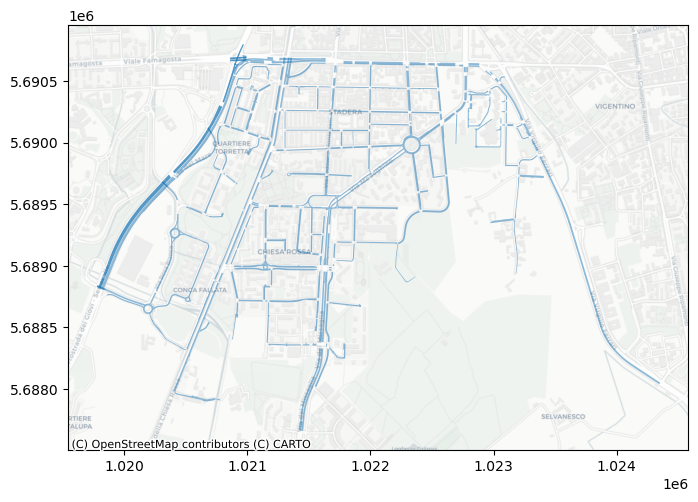

In [13]:
fig, ax = plt.subplots(1,1, figsize = (8,8))
gdf_Stadera.plot(ax = ax, alpha = 0.5)
cx.add_basemap(ax, crs=gdf_N.crs, zoom = 15, source=cx.providers.CartoDB.Positron) #providers.Esri.WorldImagery for satellite
#source=cx.providers.CartoDB.Positron)


## Creating custom ranges by distance

Here's a function to create a Geodataframe with all roads within a given distance from the road given as input

In [16]:
def within_dist(street, dist, gdf):
    #function creates gdf with all streets within distance dist (in meters) of street
    #street is a geodataframe, dist is a positive number, and gdf is the geodataframe dataset.
    temp = street.copy()
    temp.geometry = temp.geometry.buffer(dist)
    temp = temp.filter(['geometry']) #so sjoin doesn't give suffixes and i don't have to rename later
    gdf_distanced = gdf.sjoin(temp, how='inner', predicate='intersects')
    gdf_distanced = gdf_distanced.dropna()
    gdf_distanced = gdf_distanced.drop_duplicates(subset=['width'], keep='first') #removes streets within 2 buffers of a polygon
    gdf_distanced = gdf_distanced.iloc[:,:-1] #drops index_R column
    gdf_distanced.rename
    return gdf_distanced

In [19]:
M = 100
gdf_test = within_dist(gdf_Volv, M, gdf)


In [20]:
gdf_test

,NOME,AC_VEI_ZON,geometry,width,MUNICIPIO,ID_NIL,NIL
11064,VIALE GIOVANNI DA CERMENATE,01,"POLYGON Z ((1022318.942 5690639.078 112.244, 1...",22.268542,5,43,TIBALDI
11065,VIALE GIOVANNI DA CERMENATE,01,"POLYGON Z ((1022013.007 5690631.604 112.401, 1...",25.170684,5,43,TIBALDI
11657,VIA GIOVANNI PEZZOTTI,01,"POLYGON Z ((1022285.849 5690700.525 112.397, 1...",7.868528,5,43,TIBALDI
11671,VIA GIOVANNI PEZZOTTI,01,"POLYGON Z ((1022310.845 5690703.721 112.193, 1...",9.263105,5,43,TIBALDI
7963,VIA VOLVINIO,01,"POLYGON Z ((1022312.067 5690555.305 112.113, 1...",19.985595,5,42,STADERA - CHIESA ROSSA - Q.RE TORRETTA - CONCA...
7964,VIA VOLVINIO,01,"POLYGON Z ((1022302.544 5690619.405 112.142, 1...",14.348751,5,42,STADERA - CHIESA ROSSA - Q.RE TORRETTA - CONCA...
7965,VIA VOLVINIO,01,"POLYGON Z ((1022309.525 5690603.257 112.141, 1...",4.757482,5,42,STADERA - CHIESA ROSSA - Q.RE TORRETTA - CONCA...
10201,VIA FRANCESCO DE SANCTIS,01,"POLYGON Z ((1022325.064 5690443.787 112.117, 1...",6.856762,5,42,STADERA - CHIESA ROSSA - Q.RE TORRETTA - CONCA...
10328,VIA VOLVINIO,01,"POLYGON Z ((1022321.492 5690392.011 112.008, 1...",19.880371,5,42,STADERA - CHIESA ROSSA - Q.RE TORRETTA - CONCA...
10329,VIA FRANCESCO DE SANCTIS,01,"POLYGON Z ((1022019.311 5690449.283 111.817, 1...",6.892374,5,42,STADERA - CHIESA ROSSA - Q.RE TORRETTA - CONCA...


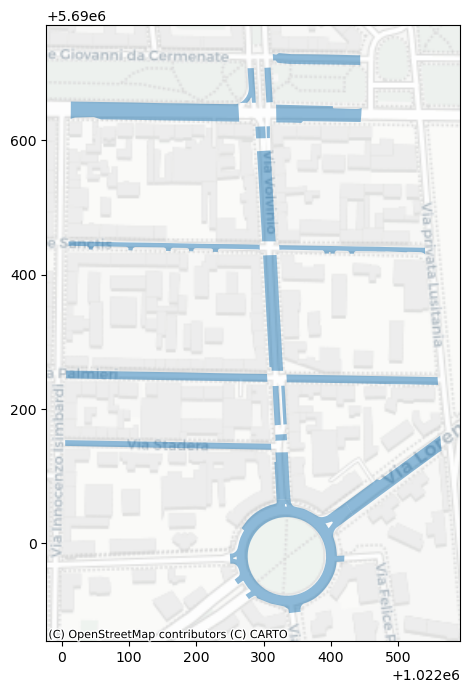

In [21]:
fig, ax = plt.subplots(1,1, figsize = (8,8))

gdf_test.plot(ax = ax, alpha = 0.5)
cx.add_basemap(ax, crs=gdf_N.crs, zoom = 16, source=cx.providers.CartoDB.Positron) #providers.Esri.WorldImagery for satellite


Let's try to plot roads color coding by width

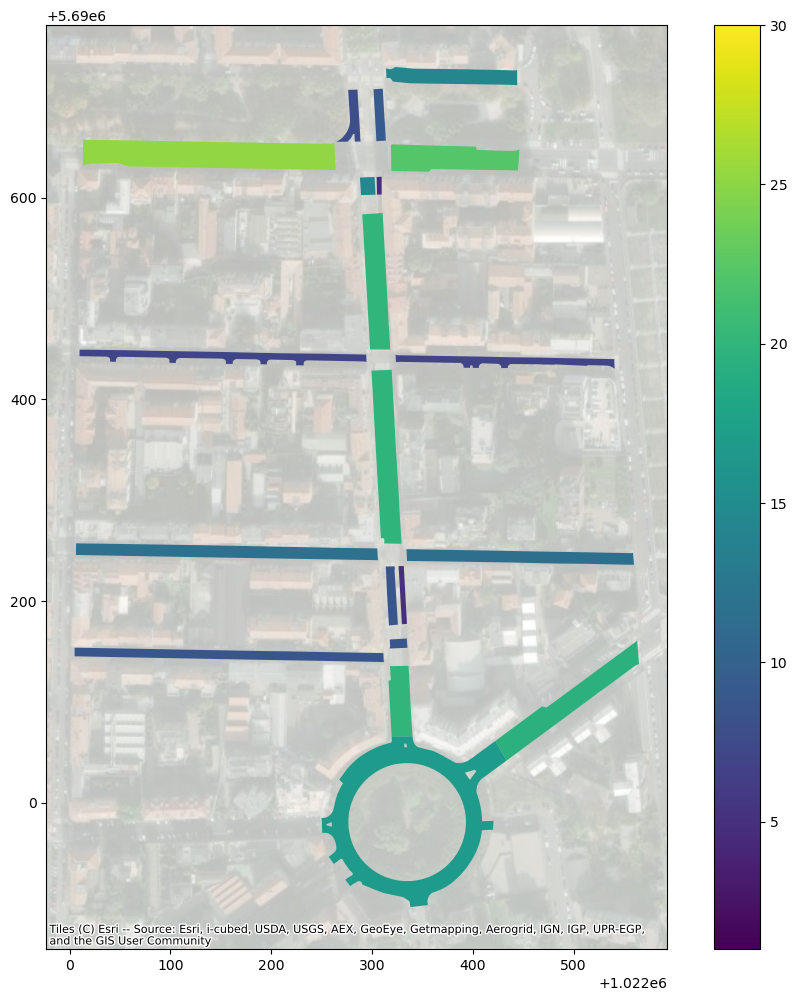

In [22]:
fig, ax = plt.subplots(1,1, figsize=(12,12))
gdf_test.plot(ax = ax, cmap = 'viridis', column = 'width', legend = True, vmin = 1, vmax = 30 )
cx.add_basemap(ax, crs=gdf_test.crs, source=cx.providers.Esri.WorldImagery, alpha =0.3) #providers.Esri.WorldImagery for satellite
plt.show()

# The Network
It should be pretty straightforward: make intersections the nodes, and make roads the edges. road width are the weights. 
However, there is a problem with what exactly it means to be an intersection.
NB for now we will consider all streets in the manner which is most convenient, i.e as two-way streets, unless otherwise specified.
### examining intersections
Let's examine the case of a relatively simple street, Via Volvinio



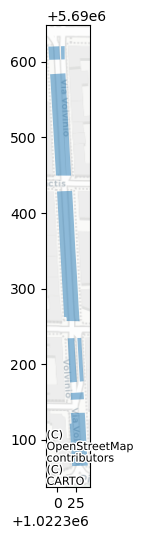

In [23]:
fig, ax = plt.subplots(1,1, figsize = (6,6))

gdf_Volv.plot(ax = ax, alpha = 0.5)
cx.add_basemap(ax, crs=gdf_N.crs, zoom = 17, source=cx.providers.CartoDB.Positron) #providers.Esri.WorldImagery for satellite


The upper part of the street divides in two, because of a barrier, then there is a blank space (considered an intersection), even though the road continues onwards without being intersected. how should this be considered? a new node seems excessive, but then what can we do? maybe after the fact i can say that that node must be eliminated since it connects to only two roads, one of which with a double connection?

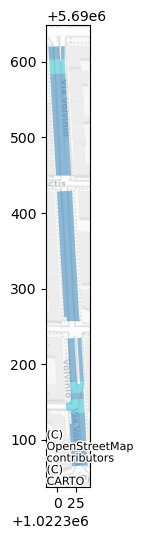

In [66]:
fig, ax = plt.subplots(1,1, figsize = (6,6))

gdf_A_Volv.plot(ax = ax, column = 'AC_VEI_ZON', alpha = 0.5)
cx.add_basemap(ax, crs=gdf_N.crs, zoom = 17, source=cx.providers.CartoDB.Positron) #providers.Esri.WorldImagery for satellite


In [67]:
gdf_A_Volv

,NOME,AC_VEI_ZON,geometry,root1,width,MUNICIPIO,ID_NIL,NIL
527,VIA VOLVINIO,0205,"POLYGON Z ((1022335.956 5690138.768 111.733, 1...",19.755868,19.755868,5,42,STADERA - CHIESA ROSSA - Q.RE TORRETTA - CONCA...
1933,VIA VOLVINIO,0205,"POLYGON Z ((1022289.034 5690602.697 112.134, 1...",25.604124,14.856836,5,42,STADERA - CHIESA ROSSA - Q.RE TORRETTA - CONCA...
1940,VIA VOLVINIO,0205,"POLYGON Z ((1022316.713 5690175.718 111.722, 1...",24.427356,9.766960,5,42,STADERA - CHIESA ROSSA - Q.RE TORRETTA - CONCA...
7853,VIA VOLVINIO,01,"POLYGON Z ((1022322.543 5690230.894 111.693, 1...",58.496526,8.768671,5,42,STADERA - CHIESA ROSSA - Q.RE TORRETTA - CONCA...
7854,VIA VOLVINIO,01,"POLYGON Z ((1022333.200 5690202.663 111.693, 1...",57.635174,5.065434,5,42,STADERA - CHIESA ROSSA - Q.RE TORRETTA - CONCA...
7855,VIA VOLVINIO,01,"POLYGON Z ((1022335.010 5690153.560 111.739, 1...",17.637780,8.766088,5,42,STADERA - CHIESA ROSSA - Q.RE TORRETTA - CONCA...
7963,VIA VOLVINIO,01,"POLYGON Z ((1022312.067 5690555.305 112.113, 1...",135.244400,19.985595,5,42,STADERA - CHIESA ROSSA - Q.RE TORRETTA - CONCA...
7964,VIA VOLVINIO,01,"POLYGON Z ((1022302.544 5690619.405 112.142, 1...",17.653661,14.348751,5,42,STADERA - CHIESA ROSSA - Q.RE TORRETTA - CONCA...
7965,VIA VOLVINIO,01,"POLYGON Z ((1022309.525 5690603.257 112.141, 1...",17.561522,4.757482,5,42,STADERA - CHIESA ROSSA - Q.RE TORRETTA - CONCA...
10216,VIA VOLVINIO,01,"POLYGON Z ((1022336.715 5690126.900 111.729, 1...",70.848212,19.927240,5,42,STADERA - CHIESA ROSSA - Q.RE TORRETTA - CONCA...


According to our pdf document, 0205 corresponds to "incrocio". I guess it's ok to consider it as such.

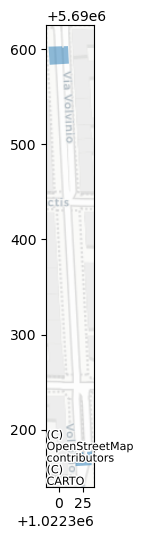

In [77]:
fig, ax = plt.subplots(1,1, figsize = (6,6))

gdf_A_Volv.loc[[1933, 1940]].plot(ax = ax, alpha = 0.5)
cx.add_basemap(ax, crs=gdf_N.crs, zoom = 17, source=cx.providers.CartoDB.Positron) #providers.Esri.WorldImagery for satellite


## Actually trying to create the network